# Load dataset QM9

This is a test script to load and display molecules of the QM9 dataset.

In [1]:
from load_qm9 import *
from display_mol import *
import matplotlib.pyplot as plt

In [2]:
ds = qm9_load_tfdata()

In [9]:
i = 0
for e in ds.take(-1):
    i += 1
print(i)

133885


(<Figure size 800x800 with 1 Axes>, <Axes3D: title={'center': 'Molécule'}>)

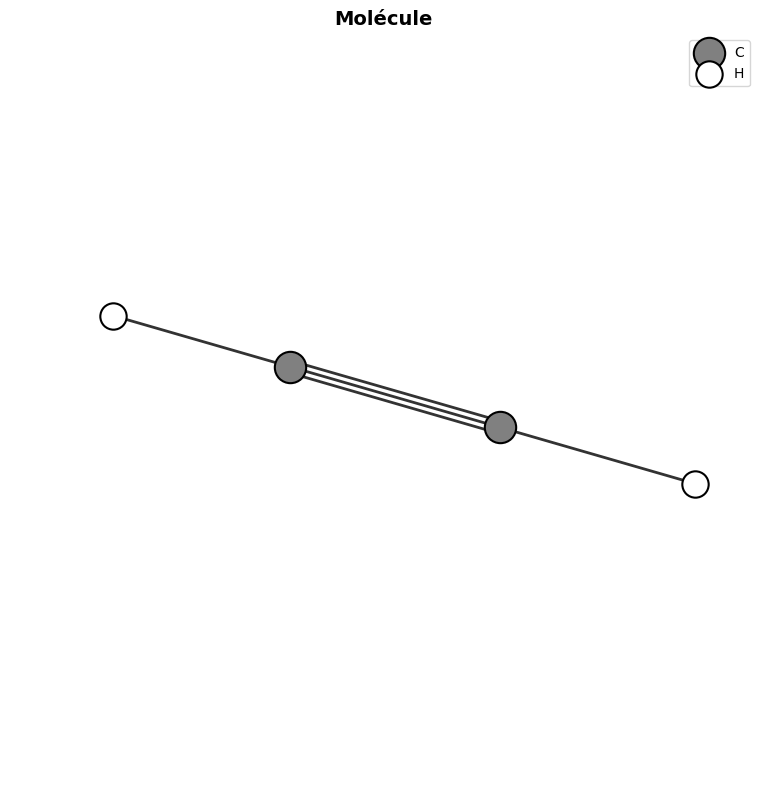

In [6]:

molecules = []
for e in ds.take(1000):
    molecules += [mol_to_dict(e)]

plot_molecule(molecules[3], figsize=(8, 8)) # 920

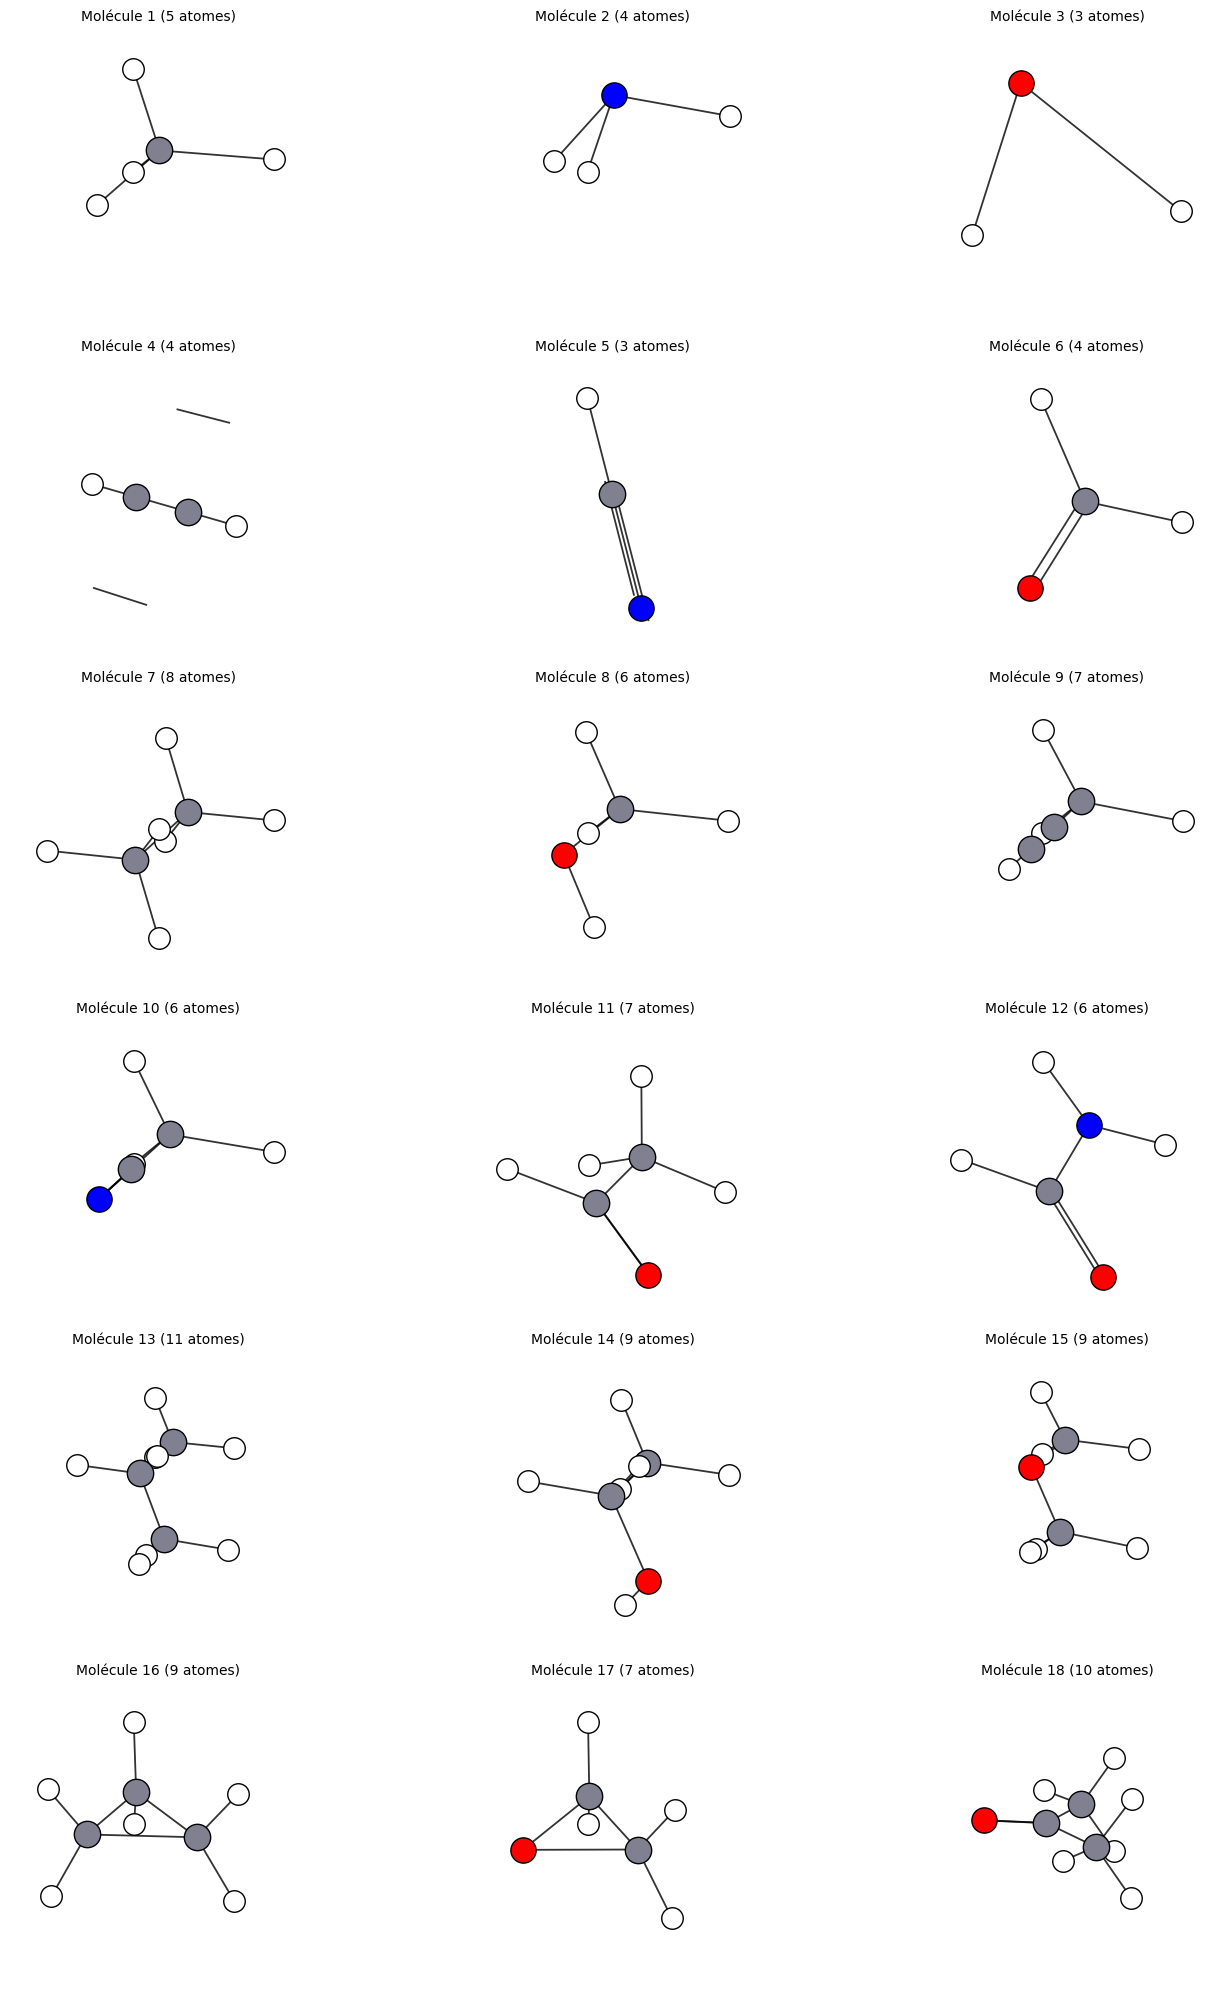

In [7]:


#plot_molecule(molecules[3], title="Première molécule du dataset QM9", show_charges=True) 
plot_multiple_molecules(molecules, 18, figsize=(15, 20))
plt.show()
